<a href="https://colab.research.google.com/github/Youssef-Hossam5/DL-AI46-SV/blob/main/Classification_Fashionmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FashionMNIST Classification using Convolutional Neural Network (PyTorch)

## Problem Description

The **FashionMNIST dataset** is a large-scale image classification problem where the goal is to classify grayscale clothing images into **10 categories**:



Each image is **28×28 grayscale pixels**, meaning the input consists of spatial pixel data rather than tabular features.


Since the data is image-based, i choose to solve it using a **Convolutional Neural Network (CNN)** — which is more appropriate for spatial feature extraction.

---

This experiment demonstrates the full Deep Learning pipeline:

* Rule 0 — Train on a single sample (Sanity Check)
* Forward propagation
* Loss computation with **CrossEntropyLoss**
* Backpropagation
* Optimization (Adam)
* Baseline establishment
* Bias / Variance analysis
* Model improvement following Golden Rules

---

# Architecture Explanation (FashionMNIST Dataset)

The network uses a small CNN:

**Input (1×28×28) → Conv → ReLU → Pool → Conv → ReLU → Pool → FC → 10**

This is suitable for medium-sized datasets like FashionMNIST (70,000 images).

| Layer                | Why                                                      |
| -------------------- | -------------------------------------------------------- |
| `Conv2d(1,16,3)`     | Extract low-level spatial features (edges, textures)     |
| `ReLU`               | Introduce non-linearity                                  |
| `MaxPool2d`          | Downsample → reduce computation + translation invariance |
| `Conv2d(16,32,3)`    | Learn higher-level patterns                              |
| `ReLU`               | Non-linearity again                                      |
| `MaxPool2d`          | Further spatial compression                              |
| `Linear(32×7×7,128)` | Learn global feature combinations                        |
| `ReLU`               | Non-linearity                                            |
| `Linear(128,10)`     | Output logits (one per class)                            |

---


## Golden Rules Applied in This Notebook

1. **Rule 0 — Sanity Check**
   Train on a single sample and verify the loss goes near zero.

2. **Establish Baseline**
   Train a simple CNN and measure validation accuracy.

3. **Reduce Bias (Underfitting)**
   If training loss is high → increase model capacity.

4. **Reduce Variance (Overfitting)**
   If validation loss is much higher than training loss → add:

   * Dropout
   * Weight decay
   * Data augmentation


In [4]:
# ==========================================
# CELL 0: Setups
# ==========================================
!pip install torch torchvision tqdm

In [5]:
# ==========================================
# CELL 1: Imports
# ==========================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

print("Torch version:", torch.__version__)

Torch version: 2.10.0+cpu


In [6]:
# ==========================================
# CELL 2: Reproducibility
# ==========================================

SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cpu


In [7]:
# ==========================================
# CELL 3: Load FashionMNIST
# ==========================================

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

val_dataset = torchvision.datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 213kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 24.1MB/s]

Train size: 60000
Validation size: 10000


In [8]:
# ==========================================
# CELL 4: Baseline Model
# ==========================================

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [9]:
# ==========================================
# CELL 5: Rule 0 - Overfit One Sample
# ==========================================

print("Rule 0: Overfitting ONE sample")

images, labels = next(iter(train_loader))

images = images[:1].to(DEVICE)
labels = labels[:1].to(DEVICE)

for i in range(300):
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

print("Final loss on single sample:", loss.item())

Rule 0: Overfitting ONE sample
Final loss on single sample: 0.0


In [10]:
# ==========================================
# CELL 6: Train & Evaluate
# ==========================================

def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            total_loss += loss.item()

    return total_loss / len(loader), correct / total

In [11]:
# ==========================================
# CELL 7: Baseline Training
# ==========================================

EPOCHS = 5

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):

    train_loss = train_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {val_acc:.4f}")
    print("----------")

Epoch 1
Train Loss: 0.6536
Val Loss: 0.4497
Val Accuracy: 0.8359
----------
Epoch 2
Train Loss: 0.3911
Val Loss: 0.3707
Val Accuracy: 0.8650
----------
Epoch 3
Train Loss: 0.3376
Val Loss: 0.3402
Val Accuracy: 0.8743
----------
Epoch 4
Train Loss: 0.3037
Val Loss: 0.3293
Val Accuracy: 0.8769
----------
Epoch 5
Train Loss: 0.2817
Val Loss: 0.3086
Val Accuracy: 0.8863
----------


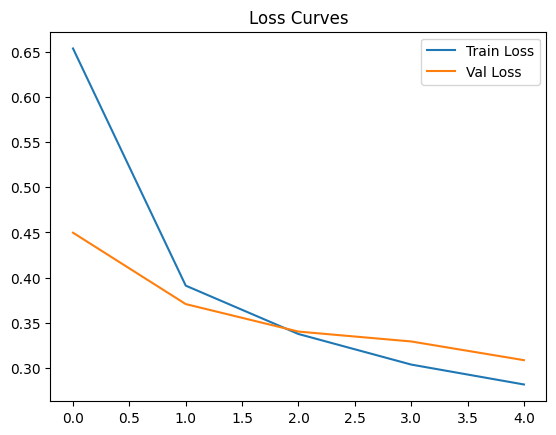

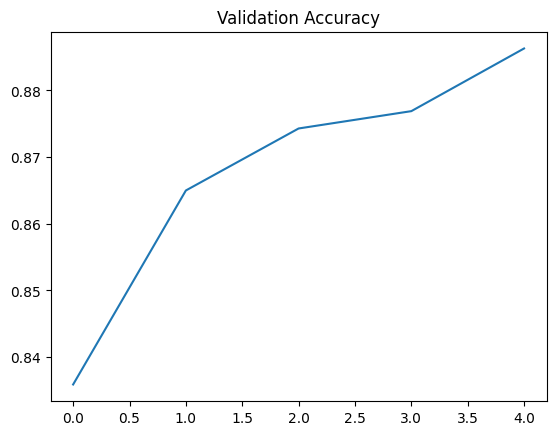

In [12]:
# ==========================================
# CELL 8: Plot Curves
# ==========================================

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Train Loss", "Val Loss"])
plt.title("Loss Curves")
plt.show()

plt.figure()
plt.plot(val_accuracies)
plt.title("Validation Accuracy")
plt.show()

In [13]:
# ==========================================
# CELL 9: Complex CNN Model (Reduce Bias)
# ==========================================

class ComplexCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the complex model
complex_model = ComplexCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(complex_model.parameters(), lr=1e-3)

print(complex_model)

ComplexCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [14]:
# ==========================================
# CELL 10: Train Complex Model (Reduce Bias)
# ==========================================

EPOCHS = 5  # start small to test
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):

    complex_model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = complex_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)

    # Validation
    complex_model.eval()
    val_loss_total = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = complex_model(images)
            val_loss = criterion(outputs, labels)
            val_loss_total += val_loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss_epoch = val_loss_total / len(val_loader)
    val_acc_epoch = correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_acc_epoch)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss_epoch:.4f} | Val Acc: {val_acc_epoch:.4f}")

Epoch 1 | Train Loss: 0.4697 | Val Loss: 0.3350 | Val Acc: 0.8748
Epoch 2 | Train Loss: 0.2748 | Val Loss: 0.2751 | Val Acc: 0.8982
Epoch 3 | Train Loss: 0.2244 | Val Loss: 0.2476 | Val Acc: 0.9114
Epoch 4 | Train Loss: 0.1908 | Val Loss: 0.2392 | Val Acc: 0.9144
Epoch 5 | Train Loss: 0.1598 | Val Loss: 0.2438 | Val Acc: 0.9147


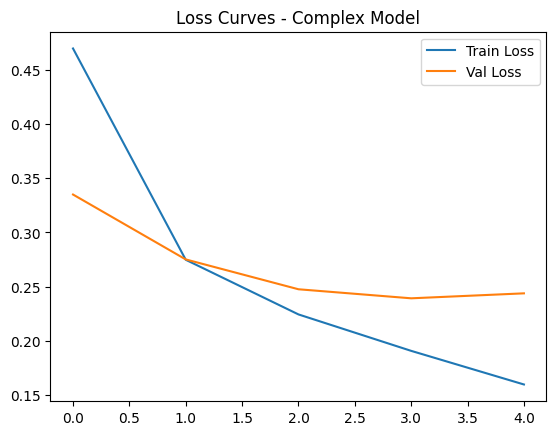

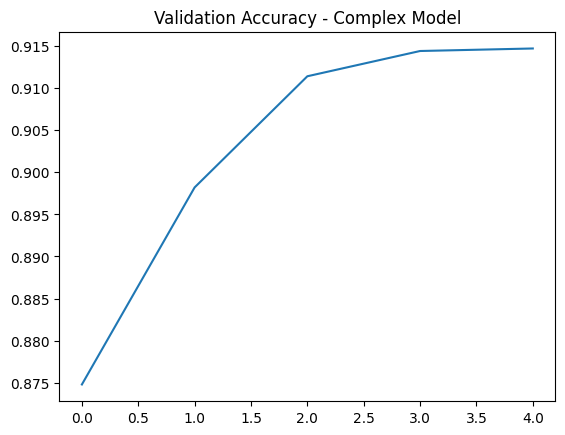

In [15]:
# ==========================================
# CELL 11: Plot Loss & Accuracy
# ==========================================

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curves - Complex Model")
plt.legend()
plt.show()

plt.figure()
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Validation Accuracy - Complex Model")
plt.show()

for step 4. **Variance Consideration**

   * At this stage, the **training loss started decreasing but its curve is close to validation loss curve **, also val loss did not start increasing so **no significant overfitting**.
   * This indicates a good balance between **bias and variance**, so additional regularization is not necessary as the model is not complex enough to overfit the data.

   the val accuracy=91.4%

